# Fraud Detection

The [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/overview) is a binary classification problem. I need to predict the probability that an online transaction is fraudulent based on the transaction information. The values of the response variable are 0 (no fraud) or 1 (fraud).

## 1. Data preprocessing

In [1]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import category_encoders
from sklearn.decomposition import PCA

### 1.1 Import and merge the data

In [2]:
path = '/home/wkm/Documents/Data set/ieee-fraud-detection/'

# import the data
train_identity = pd.read_csv(path + 'train_identity.csv')
train_transaction = pd.read_csv(path + 'train_transaction.csv')
test_identity = pd.read_csv(path + 'test_identity.csv')
test_transaction = pd.read_csv(path + 'test_transaction.csv')

# merge identity and transaction to one dataframe
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
# train_raw, test_raw = train.copy(), test.copy()

del train_identity, train_transaction, test_identity, test_transaction

In [ ]:
train_identity.columns

In [3]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
print(f'Training dataset has {train.shape[0]} observations and {train.shape[1]} features.')
print(f'Test dataset has {test.shape[0]} observations and {test.shape[1]} features.')

Training dataset has 590540 observations and 434 features.
Test dataset has 506691 observations and 433 features.


In [11]:
Ytr = train["isFraud"]
X = train.drop(["isFraud","TransactionID", "TransactionDT"], axis=1).append(test.drop(["TransactionID", "TransactionDT"], axis=1))
# X_raw, Ytr_raw = X.copy(), Ytr.copy()

### 1.2 Handle missing values

At first, I dropt features with high proporation (70%) of missing values. Then, I filled missing values in categorical variables with their mode, and filled missing values in numerical variables with their mean.

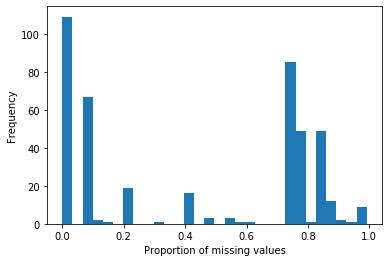

In [12]:
# proporation of missing values
missPropor = [X[col].isnull().sum() / X.shape[0] for col in X.columns]
plt.hist(missPropor, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Proportion of missing values")
plt.show()

Now let's delete features with high proporation of missing values since these variables are useless.

In [13]:
# delete features with high proporation of missing values
many_null_cols = [X.columns[i] for i in range(X.shape[1]) if missPropor[i] > 0.7]
X = X.drop(many_null_cols, axis=1)
print(f"After deleting features with high proporation of missing values, there are {X.shape[1]} features.")

After deleting features with high proporation of missing values, there are 223 features.


Let's fill the missing values. We fill missing values in categorical variables with their mode, and numerical variables with their mean.

In [14]:
# fill missing values in categorical variables with their mode.
# fill missing values in numerical variables with their mean.
for i in range(X.shape[1]):
    if missPropor[i] > 0:
        if X.iloc[:, i].dtype == "object":
            X.iloc[:, i] = X.iloc[:, i].fillna(X.iloc[:, i].mode()[0])
        elif X.iloc[:, i].dtype in ['int64', 'float64']:
            X.iloc[:, i] = X.iloc[:, i].fillna(X.iloc[:, i].mean())

### 1.3 Encode categorical variables

In the following part, I tried two different ways: numeric encoding and binary encoding. [Here](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931) is the reason why I did that.

Numeric encoding (label encoding) simply assigns a value to each category. Binary encoding hashes the cardinalities into binary values.

In [9]:
# numeric encoding (label encoding)
X_le = X.copy()
for f in X.columns:
    if X_le[f].dtype == 'object': 
        le = preprocessing.LabelEncoder()
        le.fit(list(X_le[f].values))
        X_le[f] = le.transform(list(X_le[f].values))

In [16]:
# binary encoding
X_be = X.copy()
for f in X.columns:
    if X_be[f].dtype == 'object': 
        if X_be[f].nunique() <= 2:
            le = preprocessing.LabelEncoder()
            le.fit(list(X_be[f].values))
            X_be[f] = le.transform(list(X_be[f].values))
        else:
            be = category_encoders.BinaryEncoder(cols=f)
            X_be = be.fit_transform(X_be)

### 1.4 PCA to reduce dimension

Although PCA can reduce dimension and computation time, the result showed that the prediction performance with PCA is worse. So I will not use the data after PCA to fit the model and make predictions in the modeling part.

In [11]:
X_le_pca = X_le.copy()

In [12]:
# standardize the data
scaler = preprocessing.StandardScaler()
scaler.fit(X_le_pca)
X_le_pca = scaler.transform(X_le_pca)

In [13]:
# apply PCA
# choose the minimum number of principal components 
# such that 99% of the variance is retained.
pca = PCA(0.99)
pca.fit(X_le_pca)
X_le_pca = pca.transform(X_le_pca)
X_le_pca = pd.DataFrame(X_le_pca)

In [14]:
print(f"Number of features after PCA is {X_le_pca.shape[1]}.")

(1097231, 137)

### 1.5 Save processed data

In [15]:
Xtr_le = X_le.iloc[:train.shape[0], :]
Xte_le = X_le.iloc[train.shape[0]:, :]
Xtr_be = X_be.iloc[:train.shape[0], :]
Xte_be = X_be.iloc[train.shape[0]:, :]
Xtr_le_pca = X_le_pca.iloc[:train.shape[0], :]
Xte_le_pca = X_le_pca.iloc[train.shape[0]:, :]

In [16]:
Xtr_le.to_csv(f"{path}X_train_labelencoding.csv", index=False)
Xte_le.to_csv(f"{path}X_test_labelencoding.csv", index=False)
Xtr_be.to_csv(f"{path}X_train_binaryencoding.csv", index=False)
Xte_be.to_csv(f"{path}X_test_binaryencoding.csv", index=False)
Xtr_le_pca.to_csv(f"{path}X_train_labelencoding_pca.csv", index=False)
Xte_le_pca.to_csv(f"{path}X_test_labelencoding_pca.csv", index=False)
Ytr.to_csv(f"{path}Y_train.csv", header="isFraud", index=False)

## 2. Modeling

In [39]:
import numpy as np
import pandas as pd
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.inspection.partial_dependence import plot_partial_dependence, partial_dependence
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
# Xtr = Xtr_le_pca.copy()
# Xte = Xte_le_pca.copy()
path = '/home/wkm/Documents/Data set/ieee-fraud-detection/'
Xtr = pd.read_csv(f"{path}X_train_binaryencoding.csv")
Xte = pd.read_csv(f"{path}X_test_binaryencoding.csv")
Ytr = pd.read_csv(f"{path}Y_train.csv")

In [3]:
test_transaction = pd.read_csv(path + 'test_transaction.csv')
submission = pd.DataFrame(test_transaction["TransactionID"])
del test_transaction

### 2.1 Logistic regression

The prediction score is 0.713617.

In [ ]:
lr = LogisticRegression(penalty='l2', max_iter=500, n_jobs=6, tol=1e-6, solver="sag")
lr.fit(Xtr, np.ravel(Ytr))
Yhat_lr = lr.predict_proba(Xte)
submission["isFraud"] = Yhat_lr[:, 1]
submission.to_csv(f"{path}Y_hat_logistic.csv", index=False)

### 2.2 Bagging trees

I use RandomForestClassifier and set max_features="auto", which means max_features=n_features, so it is bagging.

In [20]:
treeCount = 100

bagging = RandomForestClassifier(max_features="auto", min_samples_leaf=1, n_estimators=treeCount)
bagging.fit(Xtr, np.ravel(Ytr))
Yhat_bagging = bagging.predict_proba(Xte)
submission["isFraud"] = Yhat_bagging[:, 1]
submission.to_csv(f"{path}Y_hat_bagging.csv", index=False)

### 2.3 Random forests

#### 2.3.1 Parameters Tunning

Let's first do parameters tunning.

In [ ]:
# use oob error to find the best max_features
nFeatures = Xtr.shape[1]
oobErrList = list()
mList = [m for m in range(10, nFeatures+1, 30)]

for m in mList:
    rf = RandomForestClassifier(max_features=m, min_samples_leaf=1,\
                                oob_score=True, n_estimators=50)
    rf.fit(Xtr, np.ravel(Ytr))
    oobErrList.append(1-rf.oob_score_)
    print(m, 1-rf.oob_score_)

[0.021016357909709793, 0.018974159244081634, 0.018340840586581808, 0.018086835777424093, 0.017890405391675412, 0.01778541673722356, 0.01770921529447622, 0.017731229044603225]


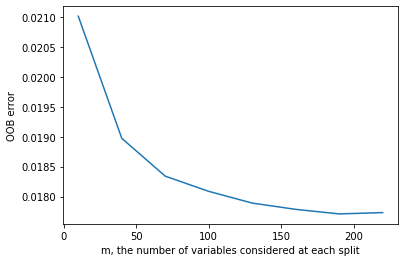

In [75]:
print(oobErrList)
plt.plot([m for m in range(10, nFeatures+1, 30)], oobErrList)
plt.ylabel('OOB error with (n_estimators=50)')
plt.xlabel('m, the number of variables considered at each split')
plt.show()

The computation is too expensive, let's select a subset from training dataframe to do parameter tunning.

In [4]:
# select a subset from training dataframe
sampleIdx = random.sample([i for i in range(Xtr.shape[0])], k=10000)
Xtr_sample2 = Xtr.iloc[sampleIdx, :]
Ytr_sample2 = Ytr.iloc[sampleIdx, :]

In [ ]:
# use oob error to find the best m
nFeatures = Xtr_sample2.shape[1]
oobErrList_sample2 = list()
mList = [m for m in range(10, nFeatures+1, 10)]

for m in mList:
    rf = RandomForestClassifier(max_features=m, min_samples_leaf=10,\
                                oob_score=True, n_estimators=200)
    rf.fit(Xtr_sample2, np.ravel(Ytr_sample2))
    oobErrList_sample2.append(1-rf.oob_score_)
    print(m, 1-rf.oob_score_)

In [ ]:
print(oobErrList_sample2)
plt.ylabel('OOB error (with n_estimators=200)')
plt.xlabel('m, the number of variables considered at each split')
plt.plot([m for m in range(10, nFeatures+1, 10)], oobErrList_sample2)
plt.show()

Other than max_features (the number of variables considered at each split), the parameter n_estimators (the number of trees) is also important. However, the prediction performance will increase with the increase of n_estimators, so we should select the highest n_estimators as long as our machine can compute it. 

I tried different parameters (max_features and n_estimators) and get the prediction scores (evaluted by AUC) as following.

|max_features | n_estimators | PCA | prediction score |
|---|---|---|---|
| 223 | 100 | 99%  | 0.871838 |
| 190 | 100 | 100% | 0.892415 |
| 100 | 100 | 100% | 0.894553 |
| 50  | 100 | 100% | 0.895868 |
| 223 | 100 | 100% | 0.896448 |
| 90  | 200 | 100% | 0.898140 |
| 100 | 200 | 100% | 0.899070 |
| 50  | 200 | 100% | 0.900798 |
| 15  | 1000| 100% | 0.904874 |

From the table above, we can see that max_features does not infulence the prediction performance significantly, but n_estimators does.

In [6]:
treeCount = 1000
m = 15

rf = RandomForestClassifier(max_features=m, min_samples_leaf=1, n_estimators=treeCount)
rf.fit(Xtr, np.ravel(Ytr))
Yhat_rf = rf.predict_proba(Xte)

In [7]:
submission["isFraud"] = Yhat_rf[:, 1]
submission.to_csv(f"{path}Y_hat_rf_m{m}_t{treeCount}.csv", index=False)

#### 2.3.2 Importances of variables

In [8]:
treeCount = 100
m = 50

rf = RandomForestClassifier(max_features=m, min_samples_leaf=1, n_estimators=treeCount)
rf.fit(Xtr_sample2, np.ravel(Ytr_sample2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=50, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

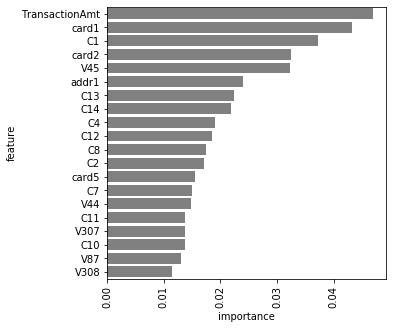

In [20]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': Xtr.columns, 'importance': rf.feature_importances_})
plt.figure(figsize=(5,5))
nShow = 20
seaborn.barplot(x='importance', y='feature', \
                data=plot_df.sort_values('importance', ascending=False)[:nShow], color='grey')
plt.xticks(rotation=90);

The plot above shows the importance of the 20 most important variables. The most important variable is `TransactionAmt`, which means the transaction payment amount is a key predictor for fraud.

#### 2.3.3 Partial Dependence Plots

In [32]:
def plot2D(classifier, X, idx:int=1):
    sorted_idx = np.argsort(classifier.feature_importances_)
    j = [sorted_idx[-idx]]
    plot_partial_dependence(classifier, X, j, feature_names=X.columns, n_jobs=3)

In [33]:
def plot3D(classifier, X, idx:tuple=(1,2), view=(45,70)):
    fig = plt.figure(figsize=(10,8))
    sorted_idx = np.argsort(classifier.feature_importances_)
    target_feature = (sorted_idx[-idx[0]], sorted_idx[-idx[1]])
    pdp, axes = partial_dependence(classifier, X, target_feature, grid_resolution=50)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
    ax.set_xlabel(X.columns[target_feature[0]])
    ax.set_ylabel(X.columns[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    plt.subplots_adjust(top=0.9)
    ax.view_init(elev=view[0], azim=view[1])
    plt.colorbar(surf)
    plt.show()

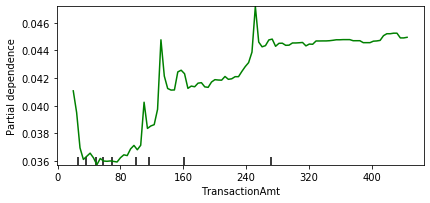

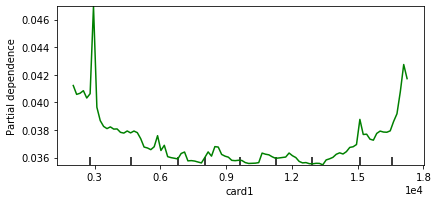

In [34]:
plot2D(rf, X=Xtr_sample2, idx=1)
plot2D(rf, X=Xtr_sample2, idx=2)

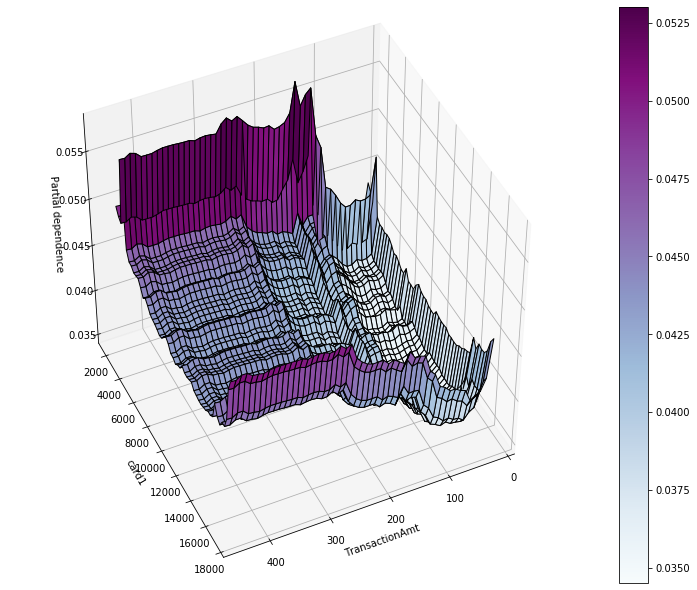

In [50]:
plot3D(rf, X=Xtr_sample2, idx=(1,2))

The plot above shows that the transaction payment amount is positively related to the fraud.

### 2.4 Gradient boosting

At first, let's try gradient boosting with default parameters. The prediction scroe on test data set is 0.891210.

In [8]:
# use default parameters
gbm0 = GradientBoostingClassifier()
gbm0.fit(Xtr, np.ravel(Ytr))
submission["isFraud"] = gbm0.predict_proba(Xte)[:, 1]
submission.to_csv(f"{path}Y_hat_gbm_default.csv", index=False)

Now let's do parameter tunning. The computation is too expensive, so I selected a subset with 50000 observations to do parameters tunning.

In [67]:
# select a subset from training dataframe
sampleIdx = random.sample([i for i in range(Xtr.shape[0])], k=50000)
Xtr_sample = Xtr.iloc[sampleIdx, :]
Ytr_sample = Ytr.iloc[sampleIdx, :]

The parameters n_estimators and learning_rate are corrlated, so we need to tune them together. Let's use grid search to find the best number of weak learners (n_estimators) and the best step size (learning_rate). 

In [ ]:
param_test1 = {'n_estimators':range(100, 1200, 100), 'learning_rate':[0.01, 0.1, 1]}
gbm_tune1 = GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=0.001, max_depth=4)

gs1 = GridSearchCV(estimator=gbm_tune1, param_grid=param_test1, iid=False, scoring='roc_auc', n_jobs=6, cv=5)
gs1.fit(Xtr_sample, np.ravel(Ytr_sample))

In [70]:
print(f"The best parameters: {gs1.best_params_}, and the highest mean_test_score is {gs1.best_score_}")

The best parameters: {'learning_rate': 0.1, 'n_estimators': 600}, and the highest mean_test_score is 0.895677005037966


However, I found that n_estimators=600 is unaffordable for computation, so I still set it to 100. Now let's tune the tree parameters max_depth and min_samples_leaf.

In [ ]:
param_test2 = {'max_depth':range(2, 16, 2), 'min_samples_leaf':[10**i for i in range(-5,0)]}
gbm_tune2 = GradientBoostingClassifier(max_features='sqrt', n_estimators=100, learning_rate=0.1)

gs2 = GridSearchCV(estimator=gbm_tune2, param_grid=param_test2, iid=False, scoring='roc_auc', n_jobs=6, cv=5)
gs2.fit(Xtr_sample, np.ravel(Ytr_sample))

In [74]:
print(f"The best parameters: {gs2.best_params_}, and the highest mean_test_score is {gs2.best_score_}")

The best parameters: {'max_depth': 10, 'min_samples_leaf': 0.001}, and the highest mean_test_score is 0.8973897459174331


In [ ]:
# use tuned parameters
gbm1 = GradientBoostingClassifier(max_depth=10, min_samples_leaf=0.001, 
                                  learning_rate=0.1, n_estimators=100)
gbm1.fit(Xtr, np.ravel(Ytr))
submission["isFraud"] = gbm1.predict_proba(Xte)[:, 1]
submission.to_csv(f"{path}Y_hat_gbm_tuned1.csv", index=False)

After parameters tuning, the prediction score (by AUC) on test data set is 0.919523. It is beeter than that without parameters tuning.

### 2.5 XGBoost

The magic parameter `tree_method='gpu_hist'`.  `gpu` means that XGBoost is running on GPU. `hist` means that it computes an approximation of the real underlying algorithm (which is a greedy algorithm). This hurts the score slightly, but as a result is much faster. If you want a more accurate result, try `tree_method='gpu_exact'`. ([Reference](https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s))

The prediction scroe on test data set by XGBoost with default parameters is 0.900976, and 0.931355 with the parameters tuned by GBT (see section 2.4 Gradient boosting).

In [ ]:
xgbc = xgb.XGBClassifier(n_jobs=4, max_depth=10, min_samples_leaf=0.001, learning_rate=0.1, 
                         n_estimators=100, eval_metric="auc", tree_method='gpu_hist')
xgbc.fit(Xtr, np.ravel(Ytr))
submission["isFraud"] = xgbc.predict_proba(Xte)[:, 1]
submission.to_csv(f"{path}Y_hat_xgb_tuned5.csv", index=False)